<a href="https://colab.research.google.com/github/Mak7k/IST2/blob/main/%D0%98%D0%A1%D0%A23_%D0%90%D0%BD%D0%B4%D1%80%D1%83%D1%88%D0%BA%D0%B5%D0%B2%D0%B8%D1%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Часть А. SVM-классификатор

Разработать SVM-классификатор для набора данных, указанного в
таблице 1.
Разбить выборку на обучающую и тестовую.
Обучить, проверить качество классификатора на обучающей и тестовой
выборках: рассчитать общую точность, Recall, Precision, F1-measure.
Оценить число опорных векторов.
Рассмотреть различные типы ядра (линейное, RBF, полиномиальное,
сигмоидное (тангенсальное)), различные сочетания значений параметра
регуляризации С и параметров ядра. Перебор по сетке (grid search).
Выбрать лучший классификатор.
Выполнить визуализацию с помощью t-sne, UMAP, TriMAP и PacMAP
(при различных сочетаниях значений их параметров): изобразить объекты
разных классов и опорные векторы разных классов разным цветом (разным
маркерами).
Сделать рисунки разбиения на классы на основе выборок с известными
метками классов и рисунки разбиения на классы с метками выставленными
классификатором.

### Импорт библиотек

In [ ]:

!pip install ucimlrepo umap-learn trimap pacmap

In [ ]:
# Установка недостающих библиотек
!pip install umap-learn trimap pacmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551807 sha256=1de21b4ab3d02e7663bb2b8fc4d3a92790bf2e1ce21d2e06f0930cbcc90f02ce
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, StandardScaler

print("Все библиотеки успешно импортированы")

Все библиотеки успешно импортированы


### Загрузка и подготовка данных

In [ ]:
# Загрузка данных Post-Operative Patient
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/postoperative-patient-data/post-operative.data"

# Имена колонок согласно описанию датасета
column_names = [
    'L-CORE', 'L-SURF', 'L-O2', 'L-BP', 'SURF-STBL', 'CORE-STBL',
    'BP-STBL', 'COMFORT', 'decision'
]

# Загружаем данные
df = pd.read_csv(url, header=None, names=column_names)

# Просмотрим данные
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nРаспределение целевой переменной:")
print(df['decision'].value_counts())


X = df.drop('decision', axis=1)
y = df['decision']


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Кодируем категориальные признаки в X
categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

print(f"\nПодготовленные данные:")
print(f"Признаки (X): {X.shape}")
print(f"Целевая переменная (y): {y_encoded.shape}")
print(f"Уникальные классы: {np.unique(y_encoded)}")

Размер датасета: (90, 9)

Первые 5 строк:
  L-CORE L-SURF       L-O2  L-BP SURF-STBL CORE-STBL     BP-STBL COMFORT  \
0    mid    low  excellent   mid    stable    stable      stable      15   
1    mid   high  excellent  high    stable    stable      stable      10   
2   high    low  excellent  high    stable    stable  mod-stable      10   
3    mid    low       good  high    stable  unstable  mod-stable      15   
4    mid    mid  excellent  high    stable    stable      stable      10   

  decision  
0        A  
1        S  
2        A  
3       A   
4        A  

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   L-CORE     90 non-null     object
 1   L-SURF     90 non-null     object
 2   L-O2       90 non-null     object
 3   L-BP       90 non-null     object
 4   SURF-STBL  90 non-null     object
 5   CORE-STBL  90 non-nul

### Обучение SVM с подбором гиперпараметров

In [ ]:
# Параметры для Grid Search
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Создание и обучение модели с Grid Search
svm_model = SVC(random_state=42)
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    cv=3,  # Уменьшим для скорости
    scoring='f1_weighted',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

# Лучшая модель
best_svm = grid_search.best_estimator_

print("Лучшие параметры SVM:")
print(f"Ядро: {best_svm.kernel}")
print(f"C: {best_svm.C}")
print(f"Gamma: {best_svm.gamma}")
print(f"Количество опорных векторов: {len(best_svm.support_vectors_)}")
print(f"Лучшая оценка CV: {grid_search.best_score_:.4f}")

Лучшие параметры SVM:
Ядро: rbf
C: 10
Gamma: 0.1
Количество опорных векторов: 149
Лучшая оценка CV: 0.9571


### Оценка качества модели


SVM - ОЦЕНКА КАЧЕСТВА
ОБУЧАЮЩАЯ ВЫБОРКА:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      1.00      1.00       179

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280

ТЕСТОВАЯ ВЫБОРКА:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        25
           1       0.98      0.93      0.96        46

    accuracy                           0.94        71
   macro avg       0.93      0.95      0.94        71
weighted avg       0.95      0.94      0.94        71



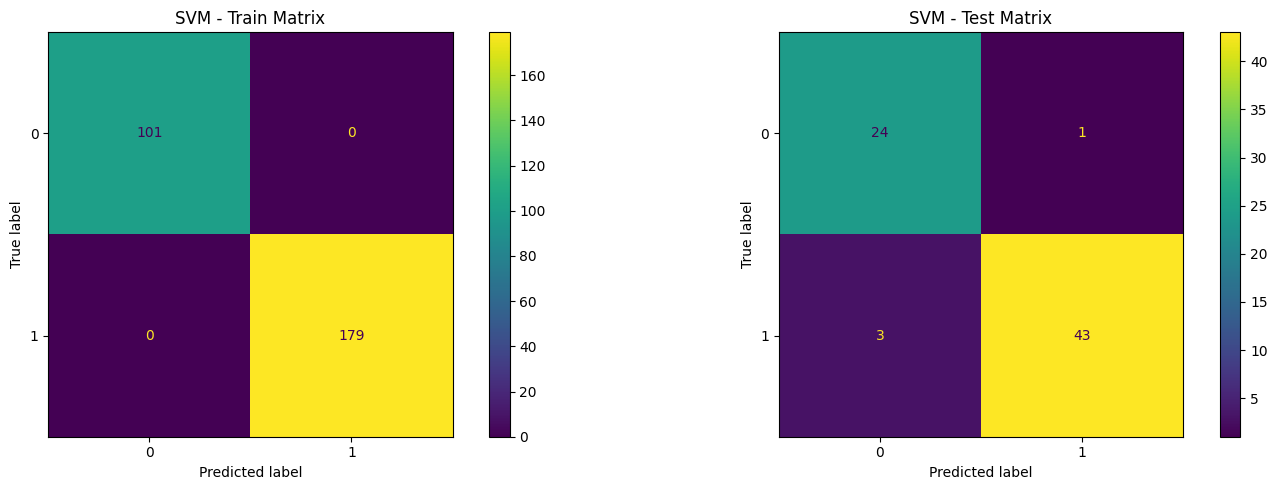

In [ ]:
def evaluate_model(model, x_train, y_train, x_test, y_test, model_name=""):
    """Функция для оценки качества модели на train и test выборках"""

    # Предсказания
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    print(f"\n{model_name} - ОЦЕНКА КАЧЕСТВА")
    print("="*50)

    # На обучающей выборке
    print("ОБУЧАЮЩАЯ ВЫБОРКА:")
    print(classification_report(y_train, y_train_pred))

    # На тестовой выборке
    print("ТЕСТОВАЯ ВЫБОРКА:")
    print(classification_report(y_test, y_test_pred))

    # Визуализация матриц ошибок
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax1)
    ax1.set_title(f'{model_name} - Train Matrix')

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax2)
    ax2.set_title(f'{model_name} - Test Matrix')

    plt.tight_layout()
    plt.show()

    return y_test_pred

# Оценка SVM модели
svm_test_pred = evaluate_model(best_svm, x_train, y_train, x_test, y_test, "SVM")

### Упрощенные функции визуализации

In [ ]:
def plot_comparison(X_embed, y_true, y_pred, title):
    """Функция для сравнения истинных и предсказанных меток"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Истинные метки
    scatter1 = ax1.scatter(X_embed[:, 0], X_embed[:, 1], c=y_true, cmap='viridis', alpha=0.7)
    ax1.set_title(f'{title} - Истинные метки')
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')
    plt.colorbar(scatter1, ax=ax1)

    # Предсказанные метки
    scatter2 = ax2.scatter(X_embed[:, 0], X_embed[:, 1], c=y_pred, cmap='viridis', alpha=0.7)
    ax2.set_title(f'{title} - Предсказанные метки')
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    plt.colorbar(scatter2, ax=ax2)

    plt.tight_layout()
    plt.show()

def apply_simple_visualizations(X_data, y_true, y_pred, method_name=""):
    """Упрощенная версия визуализаций"""

    print(f"\n{method_name} - ВИЗУАЛИЗАЦИЯ")
    print("="*40)

    # t-SNE
    print("t-SNE визуализация:")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_data)
    plot_comparison(X_tsne, y_true, y_pred, "t-SNE")

    # UMAP
    print("UMAP визуализация:")
    try:
        import umap
        reducer = umap.UMAP(random_state=42)
        X_umap = reducer.fit_transform(X_data)
        plot_comparison(X_umap, y_true, y_pred, "UMAP")
    except ImportError:
        print("UMAP не доступен")

    # TriMAP (опционально)
    print("TriMAP визуализация:")
    try:
        import trimap
        tri_reducer = trimap.TRIMAP()
        X_trimap = tri_reducer.fit_transform(X_data)
        plot_comparison(X_trimap, y_true, y_pred, "TriMAP")
    except ImportError:
        print("TriMAP не доступен")

### Визуализация результатов SVM

ВИЗУАЛИЗАЦИЯ SVM НА ТЕСТОВОЙ ВЫБОРКЕ

SVM Classifier - ВИЗУАЛИЗАЦИЯ
t-SNE визуализация:


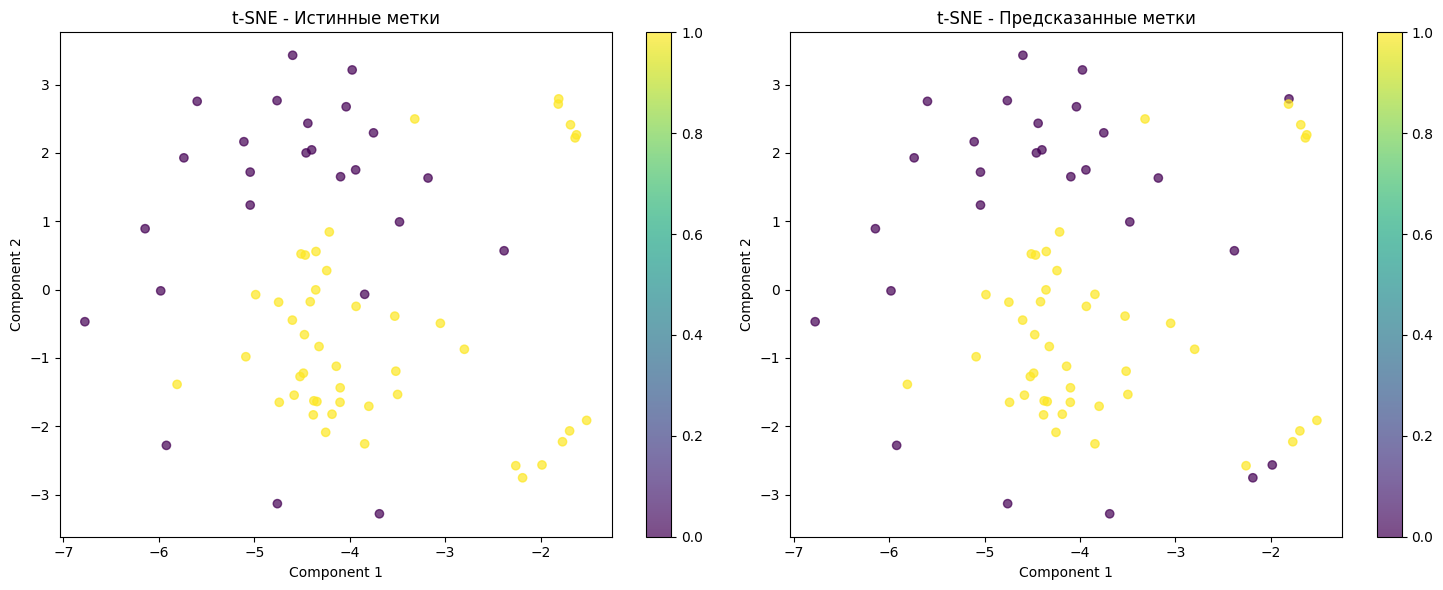

UMAP визуализация:


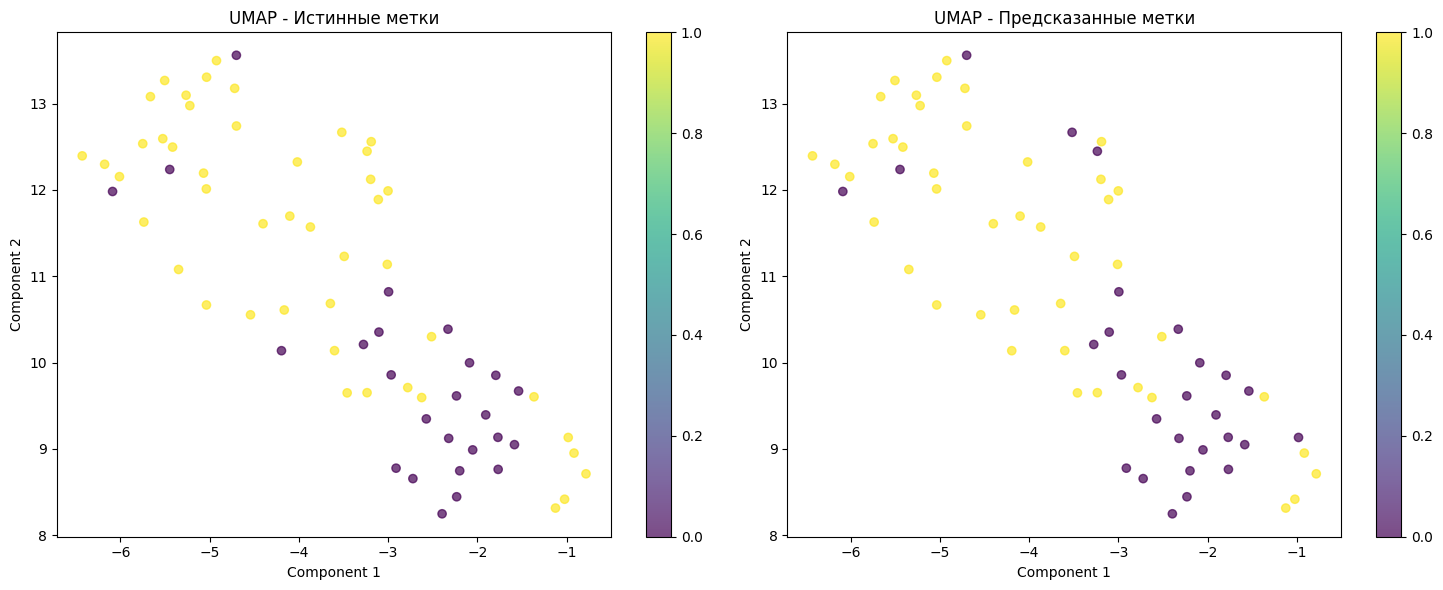

TriMAP визуализация:


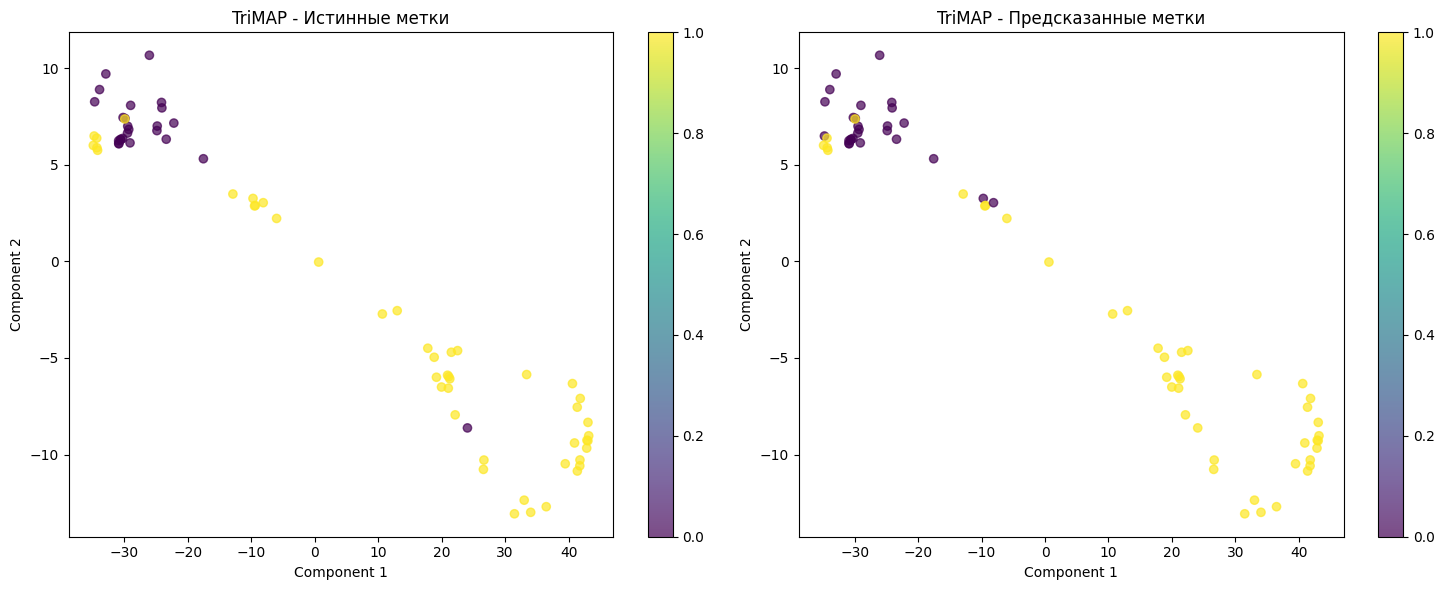


ЧАСТЬ A ЗАВЕРШЕНА!
Лучшая модель SVM: kernel=rbf, C=10, gamma=0.1
Общее количество опорных векторов: 149
Количество опорных векторов по классам: [91 58]


In [ ]:
# Визуализация на тестовой выборке
print("ВИЗУАЛИЗАЦИЯ SVM НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*50)

apply_simple_visualizations(
    x_test,
    y_test,           # Истинные метки
    svm_test_pred,    # Предсказанные метки
    method_name="SVM Classifier"
)

print("\n" + "="*60)
print("ЧАСТЬ A ЗАВЕРШЕНА!")
print(f"Лучшая модель SVM: kernel={best_svm.kernel}, C={best_svm.C}, gamma={best_svm.gamma}")
print(f"Общее количество опорных векторов: {len(best_svm.support_vectors_)}")
print(f"Количество опорных векторов по классам: {best_svm.n_support_}")
print("="*60)

# Часть В. KNN-классификатор

Разработать knn-классификатор для набора данных, указанного в
варианте методических указаний (для задания 1).
Разбить выборку на обучающую и тестовую.
Обучить, проверить качество классификатора на обучающей и тестовой
выборках: рассчитать общую точность, Recall, Precision, F1-measure.
Рассмотреть различное число ближайших соседей, различные метрики
для вычисления расстояний между объектами, различные правила
голосования. Перебор по сетке (grid search).
Выбрать лучший классификатор.
Выполнить визуализацию с помощью t-sne, UMAP, TriMAP и PacMAP
(при различных сочетаниях значений их параметров): изобразить объекты
разных классов разным цветом (разным маркерами).
Сделать рисунки разбиения на классы на основе выборок с известными
метками классов и рисунки разбиения на классы с метками выставленными
классификатором.

### Импорт библиотек для KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

### Обучение KNN с подбором гиперпараметров

In [ ]:
# Параметры для Grid Search KNN
knn_param_grid = {
    'n_neighbors': list(range(1, 21)),  # от 1 до 20 соседей
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Создание и обучение KNN модели с Grid Search
knn_model = KNeighborsClassifier()
knn_grid_search = GridSearchCV(
    estimator=knn_model,
    param_grid=knn_param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

print("Запуск Grid Search для KNN...")
knn_grid_search.fit(x_train, y_train)

# Лучшая модель KNN
best_knn = knn_grid_search.best_estimator_

print("\nЛучшие параметры KNN:")
print(f"n_neighbors: {best_knn.n_neighbors}")
print(f"weights: {best_knn.weights}")
print(f"metric: {best_knn.metric}")
print(f"Лучшая оценка CV: {knn_grid_search.best_score_:.4f}")

Запуск Grid Search для KNN...
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Лучшие параметры KNN:
n_neighbors: 2
weights: uniform
metric: manhattan
Лучшая оценка CV: 0.9197


### Функция для детальной оценки метрик


KNN - ДЕТАЛЬНАЯ ОЦЕНКА МЕТРИК
  Выборка  Accuracy  Precision  Recall  F1-Score
0   Train    0.9929     0.9930  0.9929    0.9929
1    Test    0.9296     0.9311  0.9296    0.9284


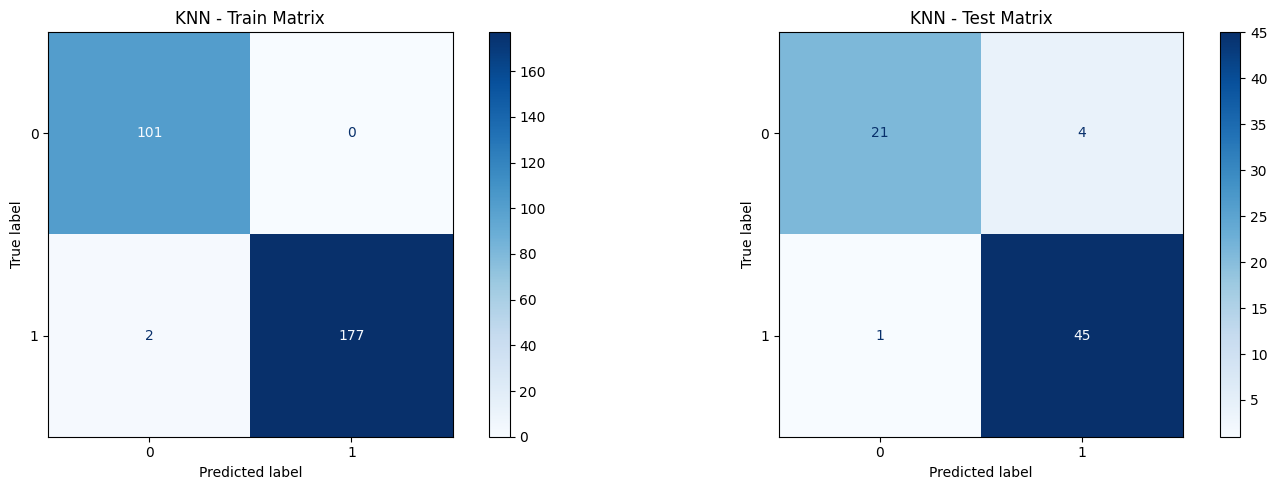

In [ ]:
def detailed_evaluation(model, x_train, y_train, x_test, y_test, model_name=""):
    """Детальная оценка модели с вычислением всех метрик"""

    # Предсказания
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Вычисление метрик для train
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')

    # Вычисление метрик для test
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    print(f"\n{model_name} - ДЕТАЛЬНАЯ ОЦЕНКА МЕТРИК")
    print("="*60)

    # Таблица с метриками
    metrics_df = pd.DataFrame({
        'Выборка': ['Train', 'Test'],
        'Accuracy': [train_accuracy, test_accuracy],
        'Precision': [train_precision, test_precision],
        'Recall': [train_recall, test_recall],
        'F1-Score': [train_f1, test_f1]
    })

    print(metrics_df.round(4))

    # Визуализация матриц ошибок
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax1, cmap='Blues')
    ax1.set_title(f'{model_name} - Train Matrix')

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax2, cmap='Blues')
    ax2.set_title(f'{model_name} - Test Matrix')

    plt.tight_layout()
    plt.show()

    return y_test_pred, metrics_df

# Оценка KNN модели
knn_test_pred, knn_metrics = detailed_evaluation(best_knn, x_train, y_train, x_test, y_test, "KNN")

### Анализ влияния количества соседей

Анализ влияния количества соседей на качество KNN:


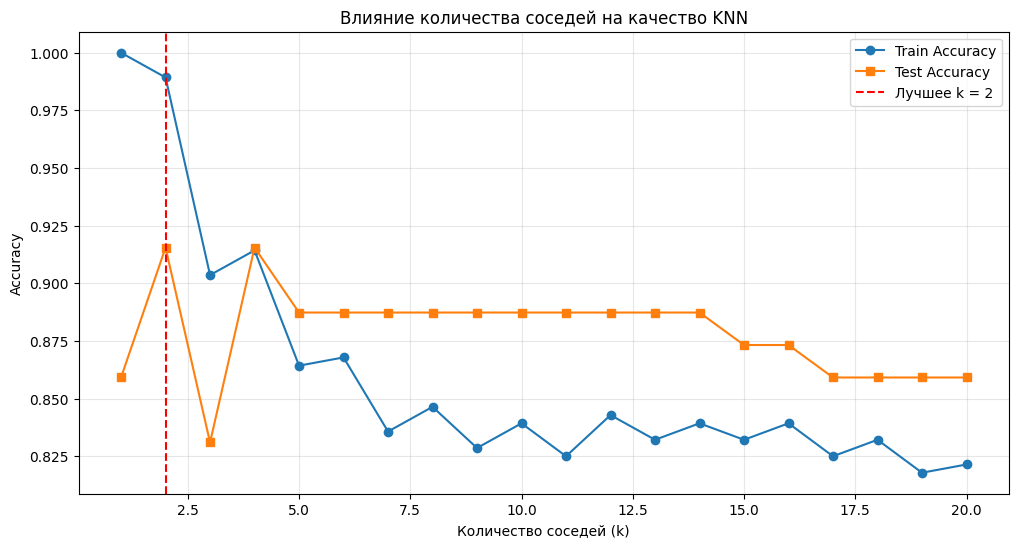

Лучшее количество соседей: 2
Максимальная accuracy на test: 0.9155


In [ ]:
# Анализ качества в зависимости от количества соседей
neighbors_range = range(1, 21)
train_scores = []
test_scores = []

print("Анализ влияния количества соседей на качество KNN:")
for n in neighbors_range:
    knn_temp = KNeighborsClassifier(n_neighbors=n)
    knn_temp.fit(x_train, y_train)

    train_score = knn_temp.score(x_train, y_train)
    test_score = knn_temp.score(x_test, y_test)

    train_scores.append(train_score)
    test_scores.append(test_score)

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(neighbors_range, train_scores, label='Train Accuracy', marker='o')
plt.plot(neighbors_range, test_scores, label='Test Accuracy', marker='s')
plt.axvline(x=best_knn.n_neighbors, color='red', linestyle='--',
            label=f'Лучшее k = {best_knn.n_neighbors}')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Accuracy')
plt.title('Влияние количества соседей на качество KNN')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Лучшее количество соседей: {best_knn.n_neighbors}")
print(f"Максимальная accuracy на test: {max(test_scores):.4f}")

### Визуализация KNN на тестовой выборке


KNN Classifier - ВИЗУАЛИЗАЦИЯ РАЗБИЕНИЯ НА КЛАССЫ
t-SNE визуализация:


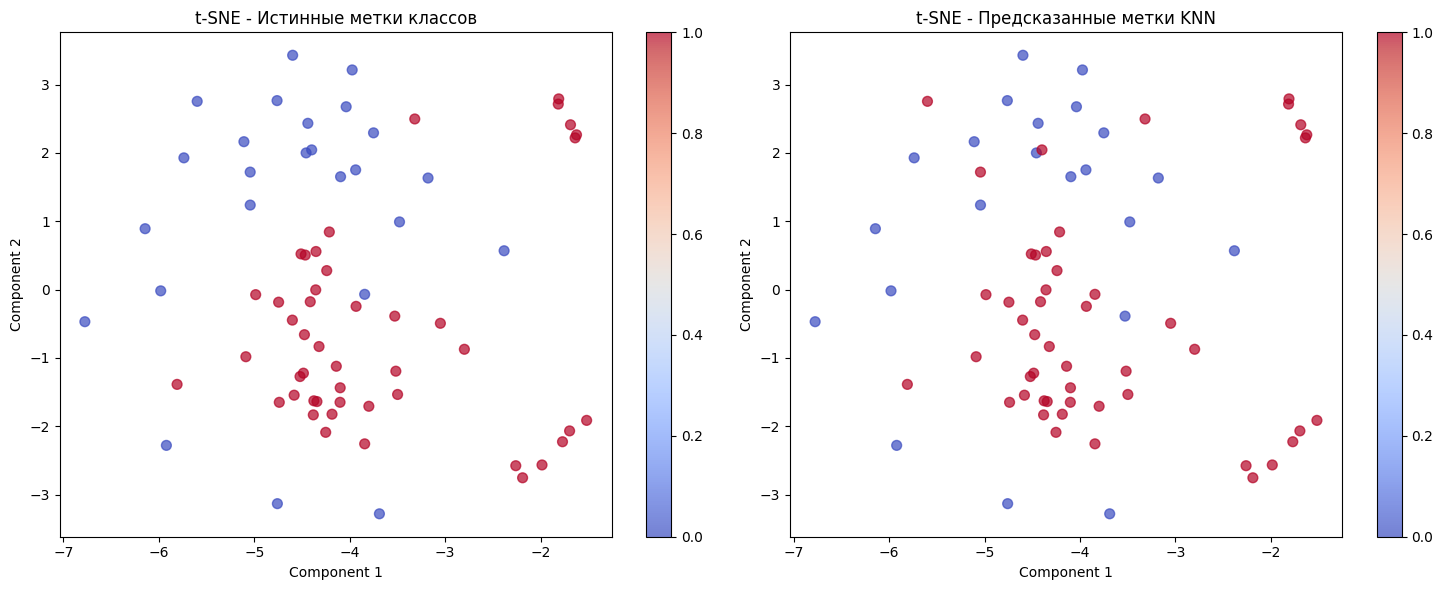

UMAP визуализация:


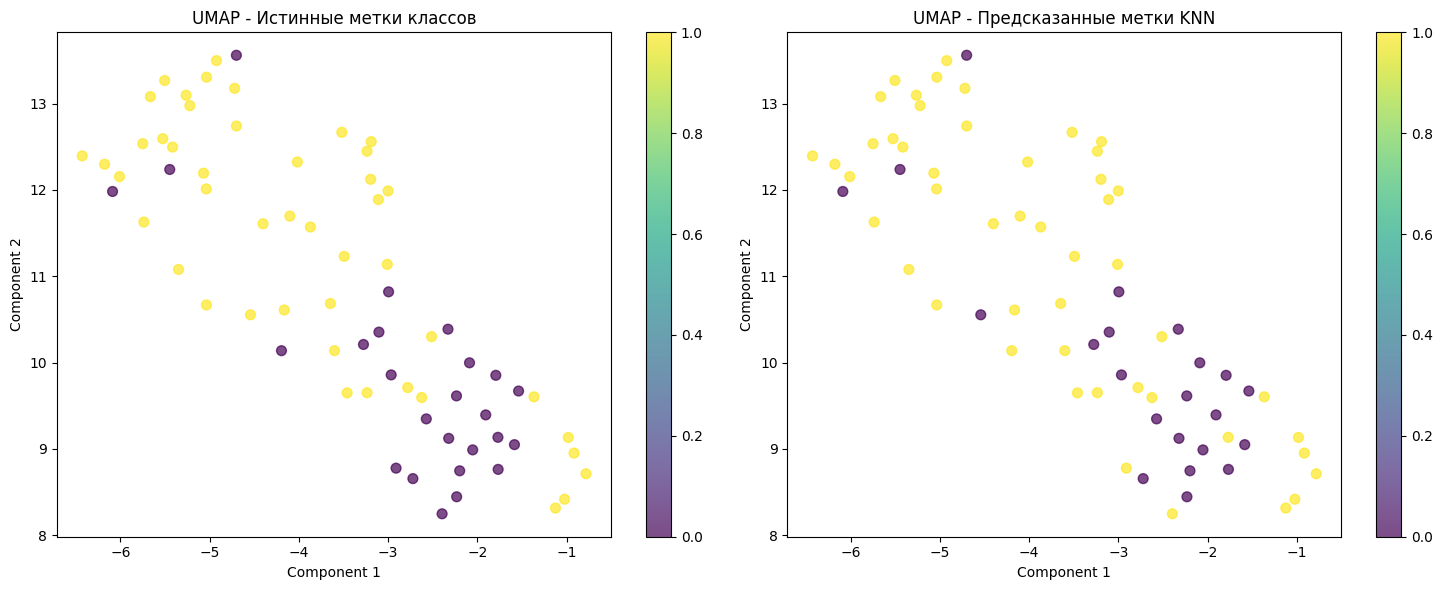

TriMAP визуализация:


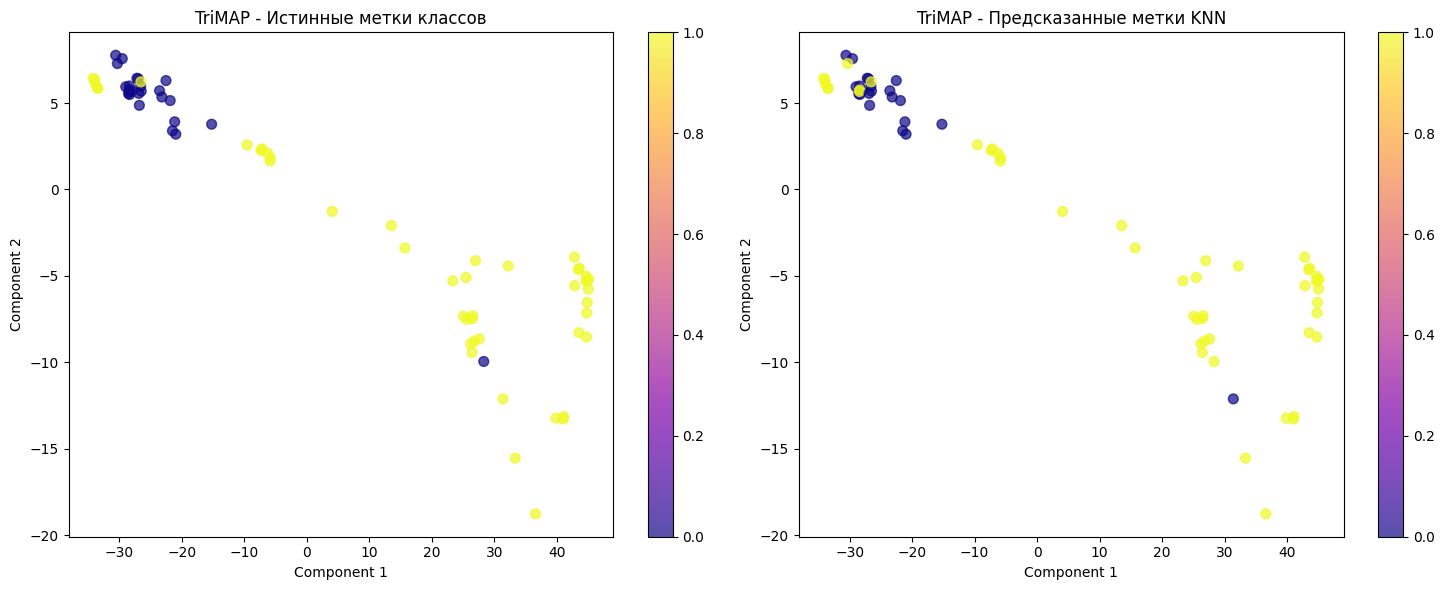

In [ ]:
def knn_visualization(X_data, y_true, y_pred, method_name=""):
    """Визуализация для KNN классификатора"""

    print(f"\n{method_name} - ВИЗУАЛИЗАЦИЯ РАЗБИЕНИЯ НА КЛАССЫ")
    print("="*50)

    # t-SNE визуализация
    print("t-SNE визуализация:")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_data)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Истинные метки
    scatter1 = ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_true, cmap='coolwarm', alpha=0.7, s=50)
    ax1.set_title('t-SNE - Истинные метки классов')
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')
    plt.colorbar(scatter1, ax=ax1)

    # Предсказанные метки
    scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred, cmap='coolwarm', alpha=0.7, s=50)
    ax2.set_title('t-SNE - Предсказанные метки KNN')
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    plt.colorbar(scatter2, ax=ax2)

    plt.tight_layout()
    plt.show()

    # UMAP визуализация
    print("UMAP визуализация:")
    try:
        import umap
        reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
        X_umap = reducer.fit_transform(X_data)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Истинные метки
        scatter1 = ax1.scatter(X_umap[:, 0], X_umap[:, 1], c=y_true, cmap='viridis', alpha=0.7, s=50)
        ax1.set_title('UMAP - Истинные метки классов')
        ax1.set_xlabel('Component 1')
        ax1.set_ylabel('Component 2')
        plt.colorbar(scatter1, ax=ax1)

        # Предсказанные метки
        scatter2 = ax2.scatter(X_umap[:, 0], X_umap[:, 1], c=y_pred, cmap='viridis', alpha=0.7, s=50)
        ax2.set_title('UMAP - Предсказанные метки KNN')
        ax2.set_xlabel('Component 1')
        ax2.set_ylabel('Component 2')
        plt.colorbar(scatter2, ax=ax2)

        plt.tight_layout()
        plt.show()

    except ImportError:
        print("UMAP не доступен")

    # TriMAP визуализация (опционально)
    print("TriMAP визуализация:")
    try:
        import trimap
        tri_reducer = trimap.TRIMAP()
        X_trimap = tri_reducer.fit_transform(X_data)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        scatter1 = ax1.scatter(X_trimap[:, 0], X_trimap[:, 1], c=y_true, cmap='plasma', alpha=0.7, s=50)
        ax1.set_title('TriMAP - Истинные метки классов')
        ax1.set_xlabel('Component 1')
        ax1.set_ylabel('Component 2')
        plt.colorbar(scatter1, ax=ax1)

        scatter2 = ax2.scatter(X_trimap[:, 0], X_trimap[:, 1], c=y_pred, cmap='plasma', alpha=0.7, s=50)
        ax2.set_title('TriMAP - Предсказанные метки KNN')
        ax2.set_xlabel('Component 1')
        ax2.set_ylabel('Component 2')
        plt.colorbar(scatter2, ax=ax2)

        plt.tight_layout()
        plt.show()

    except ImportError:
        print("TriMAP не доступен")

# Применяем визуализацию для KNN
knn_visualization(x_test, y_test, knn_test_pred, "KNN Classifier")

## Часть С. RF-классификатор

Разработать RF-классификатор (Random Forest) для набора данных,
указанного в варианте методических указаний (для задания 1).
Разбить выборку на обучающую и тестовую.
Обучить, проверить качество классификатора на обучающей и тестовой
выборках: рассчитать общую точность, Recall, Precision, F1-measure.
Рассмотреть различное число ближайших соседей, различные метрики
для вычисления расстояний между объектами, различные правила
голосования. Перебор по сетке (grid search).
Выбрать лучший классификатор.
Выполнить визуализацию с помощью t-sne, UMAP, TriMAP и PacMAP
(при различных сочетаниях значений их параметров): изобразить объекты
разных классов разным цветом (разным маркерами).
Сделать рисунки разбиения на классы на основе выборок с известными
метками классов и рисунки разбиения на классы с метками выставленными
классификатором.
Выполнить визуализацию 2 деревьев в случайном лесу, объяснить
структуру деревьев и содержимое узлов деревьев.

Импорт библиотек для Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, export_text
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Обучение Random Forest с подбором гиперпараметров

In [ ]:
# Параметры для Grid Search Random Forest
rf_param_grid = {
    'n_estimators': [50],           # Количество деревьев
    'max_depth': [5, 10, ],           # Максимальная глубина
    'min_samples_split': [2, 5],          # Минимальное количество samples для разделения
    'min_samples_leaf': [1, 2],            # Минимальное количество samples в листе
    'criterion': ['gini', 'entropy']          # Критерий разделения
}

# Создание и обучение RF модели с Grid Search
rf_model = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

print("Запуск Grid Search для Random Forest...")
rf_grid_search.fit(x_train, y_train)

# Лучшая модель RF
best_rf = rf_grid_search.best_estimator_

print("\nЛучшие параметры Random Forest:")
print(f"n_estimators: {best_rf.n_estimators}")
print(f"max_depth: {best_rf.max_depth}")
print(f"min_samples_split: {best_rf.min_samples_split}")
print(f"min_samples_leaf: {best_rf.min_samples_leaf}")
print(f"criterion: {best_rf.criterion}")
print(f"Лучшая оценка CV: {rf_grid_search.best_score_:.4f}")

Запуск Grid Search для Random Forest...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Лучшие параметры Random Forest:
n_estimators: 50
max_depth: 10
min_samples_split: 2
min_samples_leaf: 1
criterion: entropy
Лучшая оценка CV: 0.9312


Оценка качества Random Forest


Random Forest - ДЕТАЛЬНАЯ ОЦЕНКА МЕТРИК
  Выборка  Accuracy  Precision  Recall  F1-Score
0   Train    0.9964     0.9964  0.9964    0.9964
1    Test    0.9437     0.9437  0.9437    0.9437


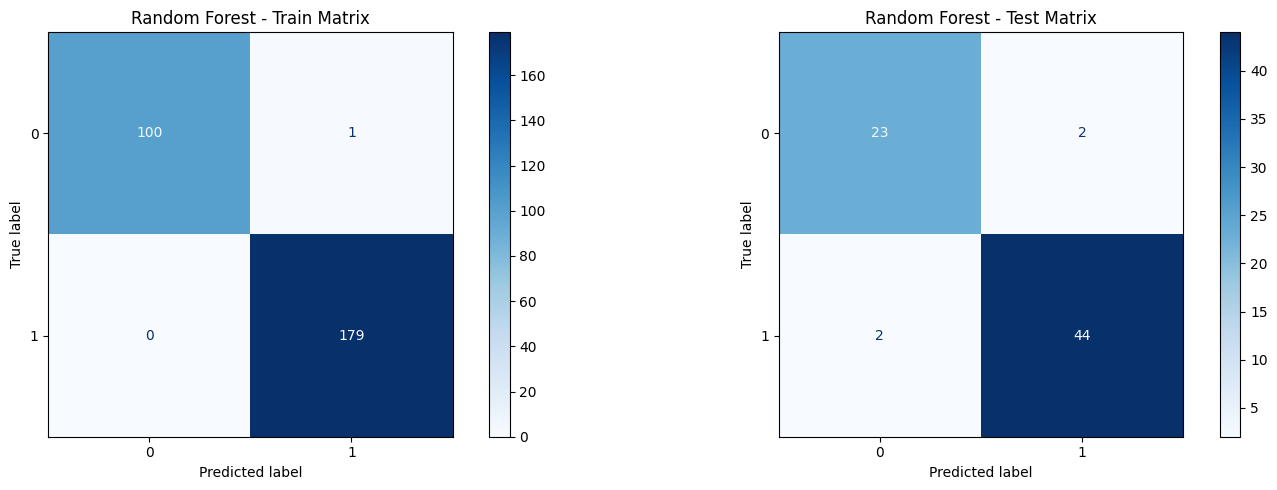


ТОП-10 самых важных признаков:
   Feature  Importance
6      a07    0.117160
4      a05    0.098858
26     a27    0.094325
2      a03    0.074120
5      a06    0.042393
3      a04    0.037979
11     a12    0.037280
27     a28    0.034823
30     a31    0.029749
23     a24    0.025823


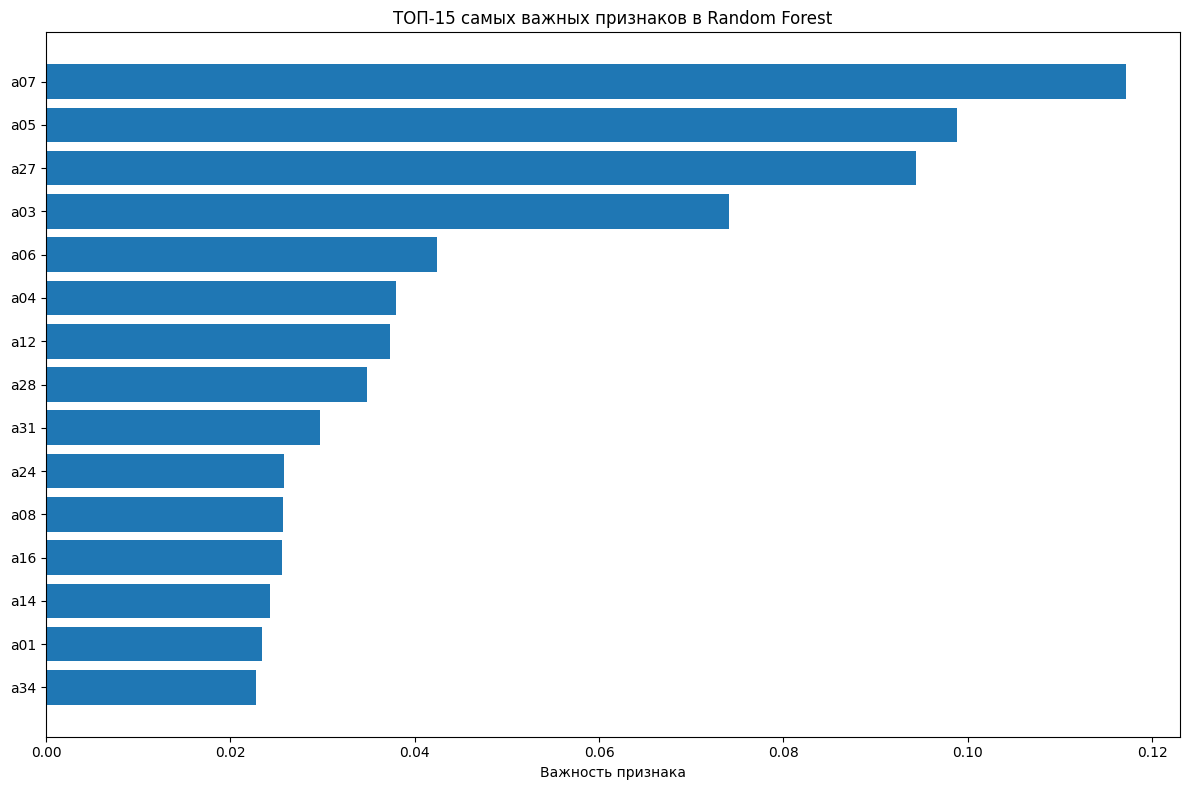

In [ ]:
# Оценка RF модели
rf_test_pred, rf_metrics = detailed_evaluation(best_rf, x_train, y_train, x_test, y_test, "Random Forest")

# Важность признаков
feature_importance = best_rf.feature_importances_
feature_names = ionosphere.feature_names if hasattr(ionosphere, 'feature_names') else [f'Feature_{i}' for i in range(X.shape[1])]

# Создаем DataFrame с важностью признаков
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\nТОП-10 самых важных признаков:")
print(importance_df.head(10))

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Важность признака')
plt.title('ТОП-15 самых важных признаков в Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Визуализация Random Forest на тестовой выборке


Random Forest Classifier - ВИЗУАЛИЗАЦИЯ РАЗБИЕНИЯ НА КЛАССЫ
t-SNE визуализация:


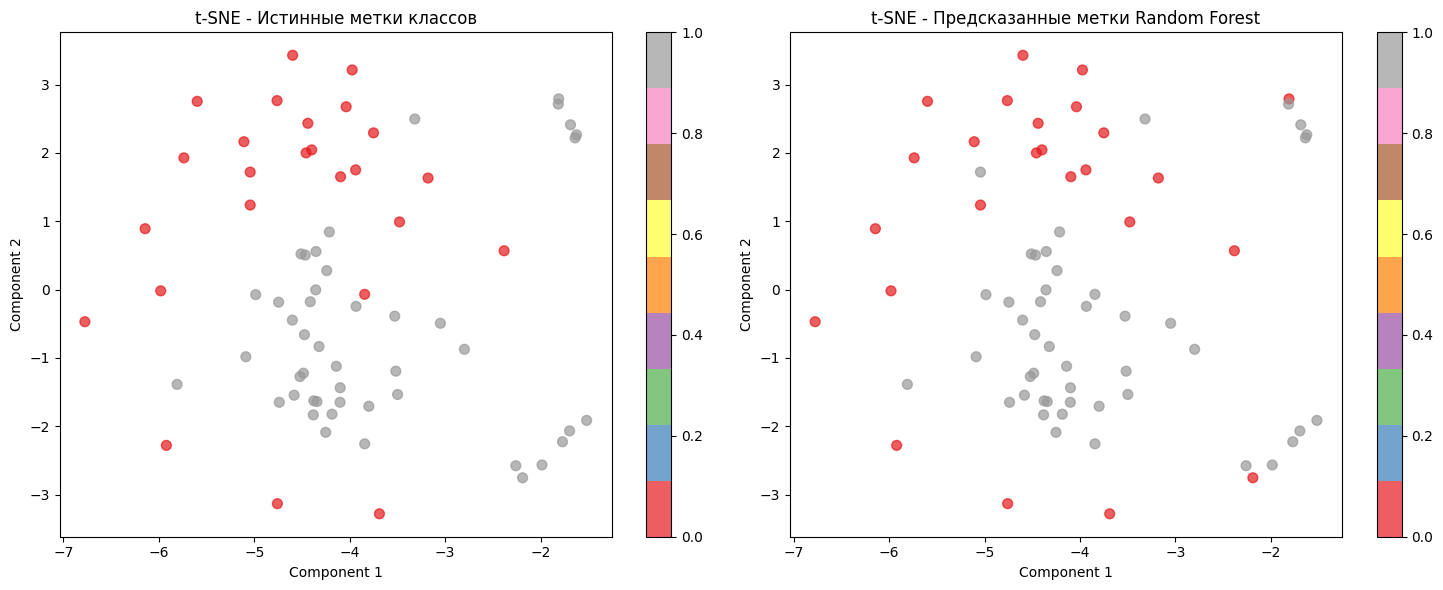

UMAP визуализация:


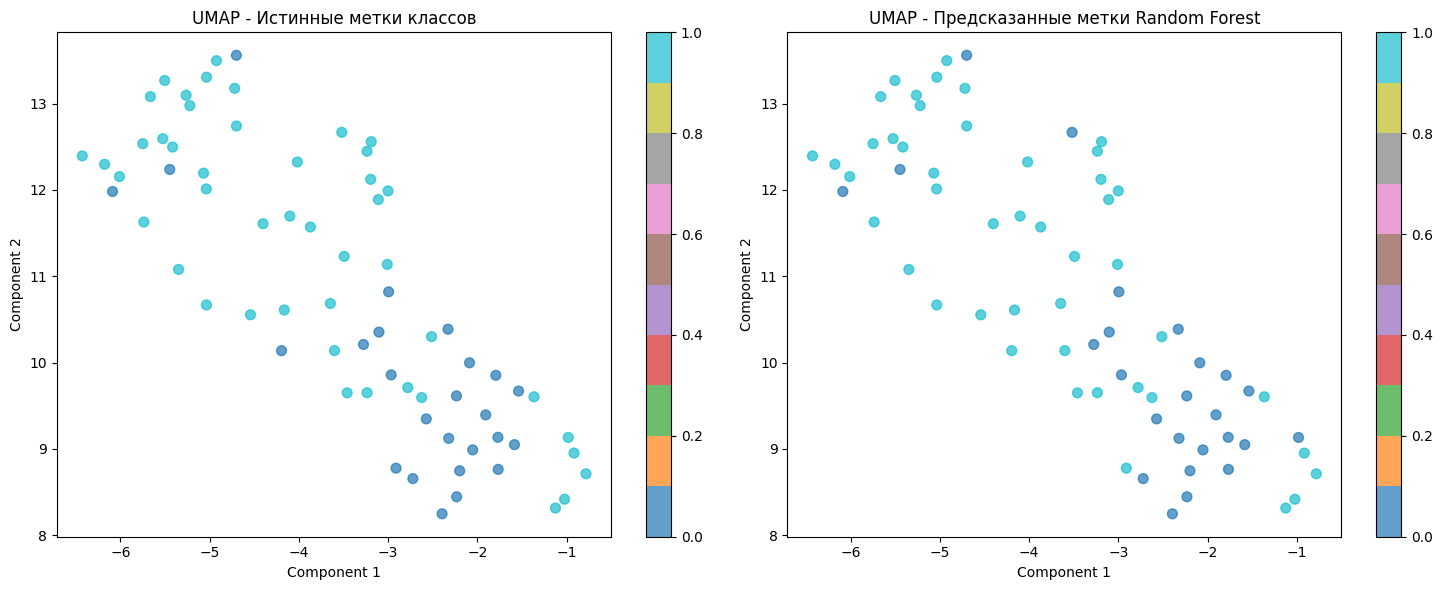

In [ ]:
def rf_visualization(X_data, y_true, y_pred, method_name=""):
    """Визуализация для Random Forest классификатора"""

    print(f"\n{method_name} - ВИЗУАЛИЗАЦИЯ РАЗБИЕНИЯ НА КЛАССЫ")
    print("="*50)

    # t-SNE визуализация
    print("t-SNE визуализация:")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_data)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Истинные метки
    scatter1 = ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_true, cmap='Set1', alpha=0.7, s=50)
    ax1.set_title('t-SNE - Истинные метки классов')
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')
    plt.colorbar(scatter1, ax=ax1)

    # Предсказанные метки
    scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred, cmap='Set1', alpha=0.7, s=50)
    ax2.set_title('t-SNE - Предсказанные метки Random Forest')
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    plt.colorbar(scatter2, ax=ax2)

    plt.tight_layout()
    plt.show()

    # UMAP визуализация
    print("UMAP визуализация:")
    try:
        import umap
        reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
        X_umap = reducer.fit_transform(X_data)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Истинные метки
        scatter1 = ax1.scatter(X_umap[:, 0], X_umap[:, 1], c=y_true, cmap='tab10', alpha=0.7, s=50)
        ax1.set_title('UMAP - Истинные метки классов')
        ax1.set_xlabel('Component 1')
        ax1.set_ylabel('Component 2')
        plt.colorbar(scatter1, ax=ax1)

        # Предсказанные метки
        scatter2 = ax2.scatter(X_umap[:, 0], X_umap[:, 1], c=y_pred, cmap='tab10', alpha=0.7, s=50)
        ax2.set_title('UMAP - Предсказанные метки Random Forest')
        ax2.set_xlabel('Component 1')
        ax2.set_ylabel('Component 2')
        plt.colorbar(scatter2, ax=ax2)

        plt.tight_layout()
        plt.show()

    except ImportError:
        print("UMAP не доступен")

# Применяем визуализацию для Random Forest
rf_visualization(x_test, y_test, rf_test_pred, "Random Forest Classifier")

Визуализация деревьев из Random Forest

ВИЗУАЛИЗАЦИЯ ДЕРЕВЬЕВ ИЗ СЛУЧАЙНОГО ЛЕСА


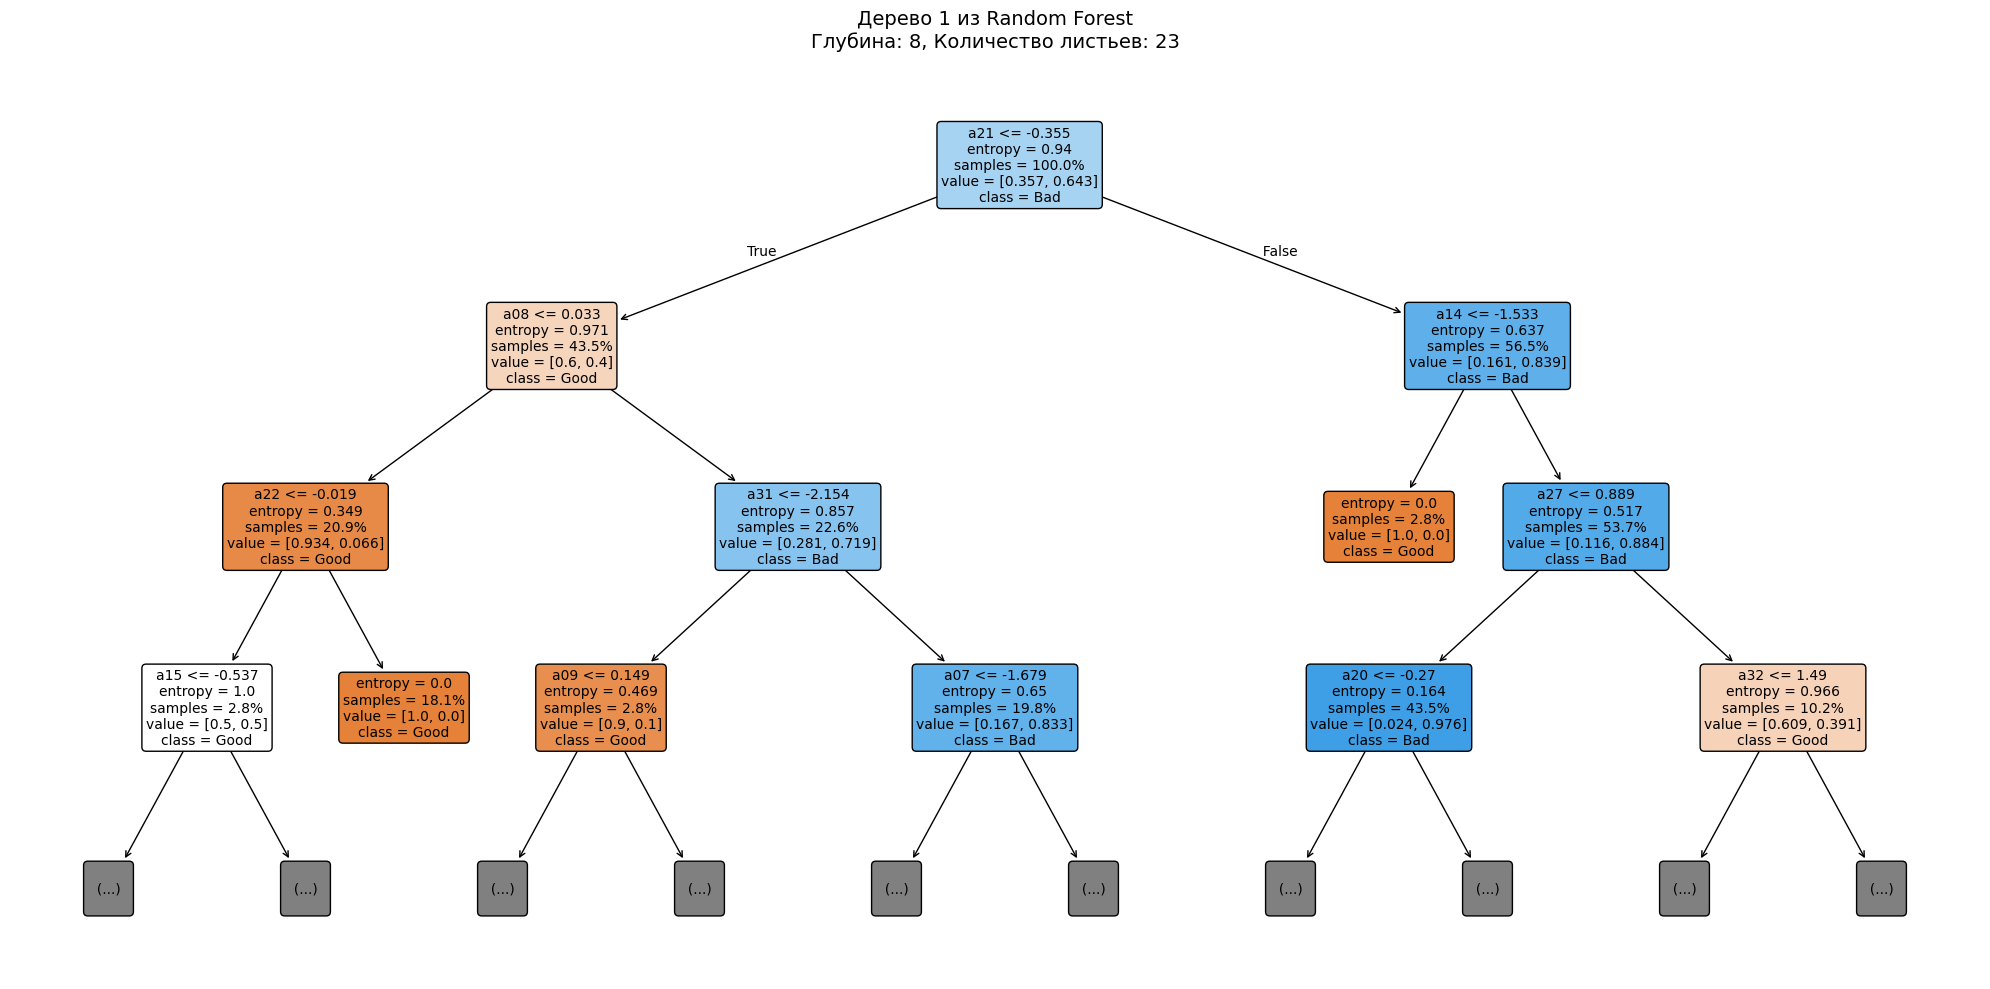


АНАЛИЗ ДЕРЕВА 1:
- Глубина дерева: 8
- Количество листьев: 23
- Количество узлов: 45

Пример структуры узлов (первые 3 уровня):
Узел 0: a21 <= -0.355
  Узел 1: a08 <= 0.033
    Узел 2: a22 <= -0.019
      Узел 3: a15 <= -0.537
      Лист 8: класс 0, samples: 32
    Узел 9: a31 <= -2.154
      Узел 10: a09 <= 0.149
      Узел 13: a07 <= -1.679
  Узел 24: a14 <= -1.533
    Лист 25: класс 0, samples: 5
    Узел 26: a27 <= 0.889
      Узел 27: a20 <= -0.270
      Узел 36: a32 <= 1.490


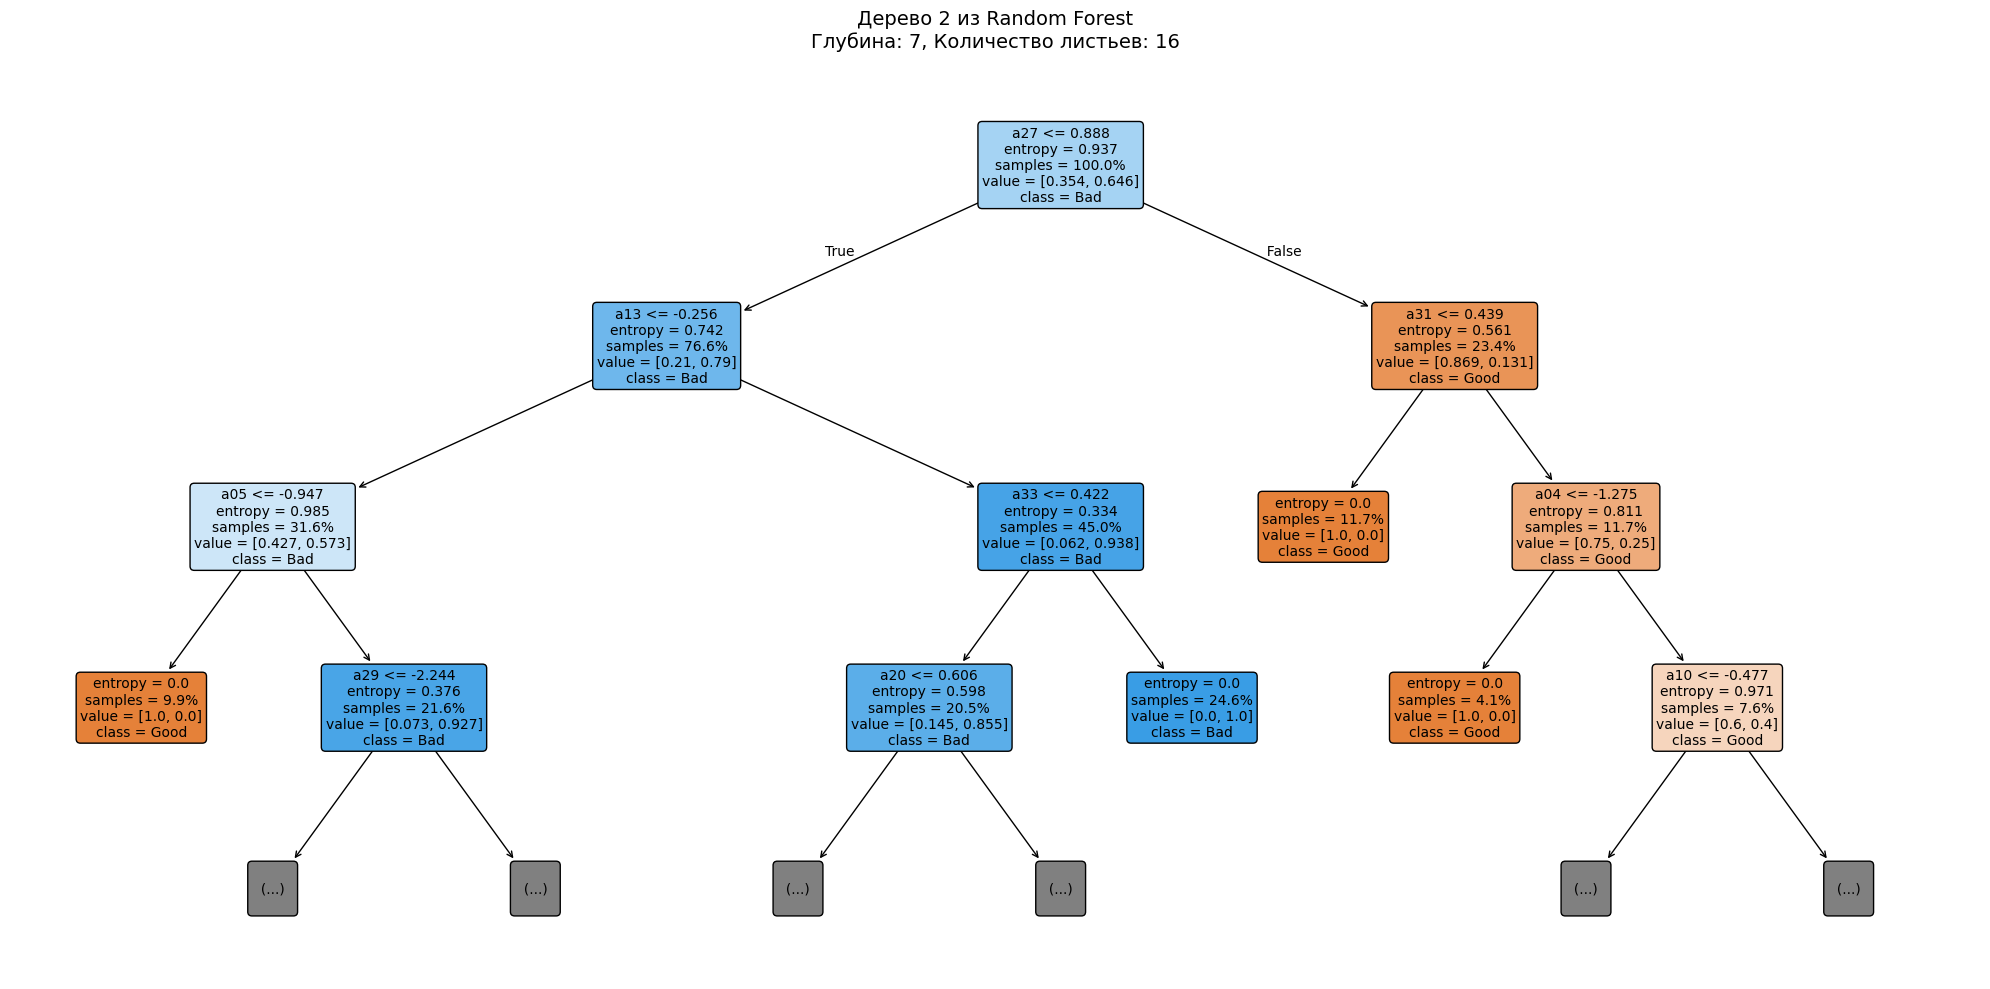


АНАЛИЗ ДЕРЕВА 2:
- Глубина дерева: 7
- Количество листьев: 16
- Количество узлов: 31

Пример структуры узлов (первые 3 уровня):
Узел 0: a27 <= 0.888
  Узел 1: a13 <= -0.256
    Узел 2: a05 <= -0.947
      Лист 3: класс 0, samples: 17
      Узел 4: a29 <= -2.244
    Узел 7: a33 <= 0.422
      Узел 8: a20 <= 0.606
      Лист 17: класс 1, samples: 42
  Узел 18: a31 <= 0.439
    Лист 19: класс 0, samples: 20
    Узел 20: a04 <= -1.275
      Лист 21: класс 0, samples: 7
      Узел 22: a10 <= -0.477


In [ ]:
def visualize_random_forest_trees(rf_model, feature_names, class_names, max_depth=3):
    """Визуализация 2 деревьев из случайного леса с объяснением структуры"""

    print("ВИЗУАЛИЗАЦИЯ ДЕРЕВЬЕВ ИЗ СЛУЧАЙНОГО ЛЕСА")
    print("="*50)

    # Выбираем первые 2 дерева для визуализации
    trees_to_visualize = [0, 1]

    for i, tree_idx in enumerate(trees_to_visualize):
        plt.figure(figsize=(20, 10))
        tree = rf_model.estimators_[tree_idx]

        # Визуализация дерева
        plot_tree(tree,
                 feature_names=feature_names,
                 class_names=class_names,
                 filled=True,
                 rounded=True,
                 proportion=True,
                 max_depth=max_depth,  # Ограничиваем глубину для читаемости
                 fontsize=10)

        plt.title(f'Дерево {tree_idx + 1} из Random Forest\n'
                 f'Глубина: {tree.get_depth()}, '
                 f'Количество листьев: {tree.get_n_leaves()}',
                 fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()

        # Анализ структуры дерева
        print(f"\nАНАЛИЗ ДЕРЕВА {tree_idx + 1}:")
        print(f"- Глубина дерева: {tree.get_depth()}")
        print(f"- Количество листьев: {tree.get_n_leaves()}")
        print(f"- Количество узлов: {tree.tree_.node_count}")

        # Пример правил из корневого узла
        print("\nПример структуры узлов (первые 3 уровня):")
        print_tree_structure(tree, feature_names, max_level=3)

def print_tree_structure(tree, feature_names, max_level=3, node_id=0, level=0):
    """Рекурсивная функция для вывода структуры дерева"""
    if level > max_level:
        return

    indent = "  " * level
    node = tree.tree_

    if node.feature[node_id] != -2:  # Если не листовой узел
        feature_name = feature_names[node.feature[node_id]]
        threshold = node.threshold[node_id]
        print(f"{indent}Узел {node_id}: {feature_name} <= {threshold:.3f}")

        # Рекурсивно обходим левого и правого ребенка
        print_tree_structure(tree, feature_names, max_level, node.children_left[node_id], level + 1)
        print_tree_structure(tree, feature_names, max_level, node.children_right[node_id], level + 1)
    else:
        # Листовой узел
        class_id = np.argmax(node.value[node_id])
        samples = node.n_node_samples[node_id]
        print(f"{indent}Лист {node_id}: класс {class_id}, samples: {samples}")

# Визуализируем деревья
class_names = ['Good', 'Bad']  # g=0 -> Good, b=1 -> Bad
visualize_random_forest_trees(best_rf, feature_names, class_names, max_depth=3)

Сравнение всех трех моделей


СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ
          Модель  Accuracy  F1-Score       Лучшие параметры
0            SVM    0.9437    0.9441       kernel=rbf, C=10
1            KNN    0.9296    0.9284  k=2, metric=manhattan
2  Random Forest    0.9437    0.9437     trees=50, depth=10


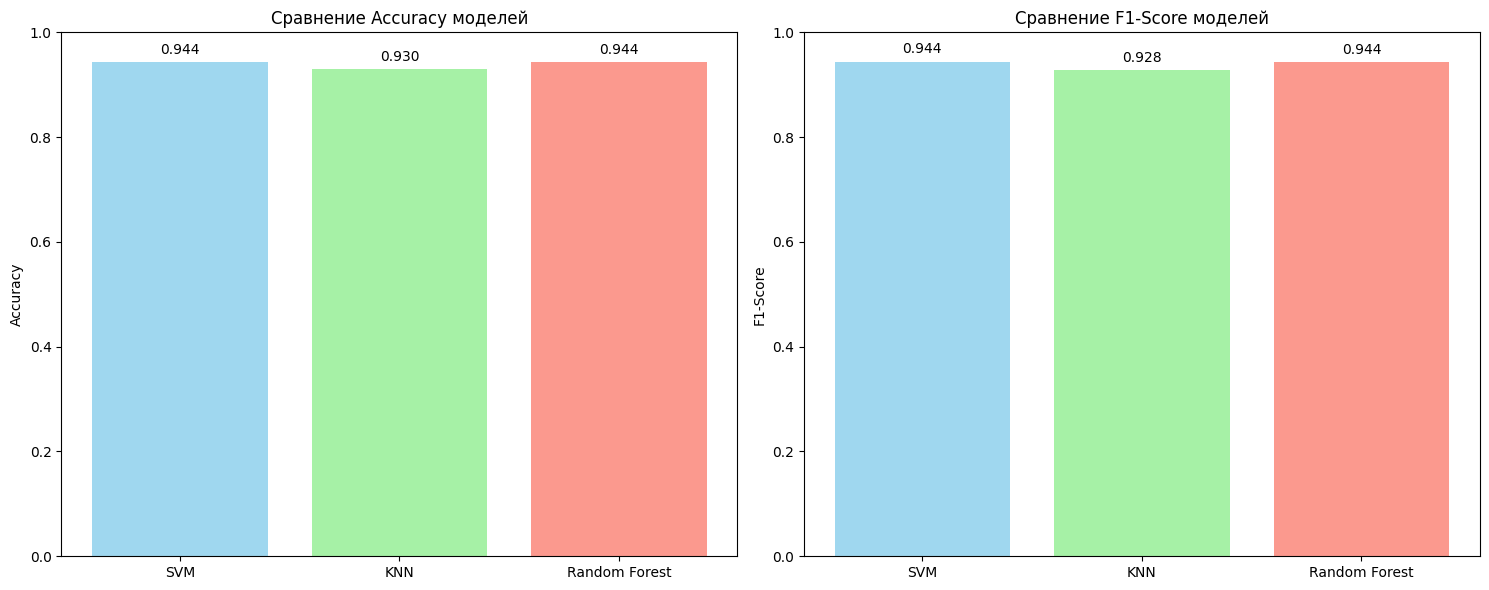


 ЛУЧШАЯ МОДЕЛЬ: SVM
   F1-Score: 0.9441
   Accuracy: 0.9437
   Параметры: kernel=rbf, C=10


In [ ]:
# Сравнение всех трех моделей
print("\n" + "="*70)
print("СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ")
print("="*70)

# Метрики всех моделей
svm_accuracy = accuracy_score(y_test, svm_test_pred)
svm_f1 = f1_score(y_test, svm_test_pred, average='weighted')

knn_accuracy = accuracy_score(y_test, knn_test_pred)
knn_f1 = f1_score(y_test, knn_test_pred, average='weighted')

rf_accuracy = accuracy_score(y_test, rf_test_pred)
rf_f1 = f1_score(y_test, rf_test_pred, average='weighted')

# Создаем таблицу сравнения
final_comparison = pd.DataFrame({
    'Модель': ['SVM', 'KNN', 'Random Forest'],
    'Accuracy': [svm_accuracy, knn_accuracy, rf_accuracy],
    'F1-Score': [svm_f1, knn_f1, rf_f1],
    'Лучшие параметры': [
        f"kernel={best_svm.kernel}, C={best_svm.C}",
        f"k={best_knn.n_neighbors}, metric={best_knn.metric}",
        f"trees={best_rf.n_estimators}, depth={best_rf.max_depth}"
    ]
})

print(final_comparison.round(4))

# Визуализация итогового сравнения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# График Accuracy
models = ['SVM', 'KNN', 'Random Forest']
accuracies = [svm_accuracy, knn_accuracy, rf_accuracy]
bars1 = ax1.bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'], alpha=0.8)
ax1.set_ylabel('Accuracy')
ax1.set_title('Сравнение Accuracy моделей')
ax1.set_ylim(0, 1)
for bar, acc in zip(bars1, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

# График F1-Score
f1_scores = [svm_f1, knn_f1, rf_f1]
bars2 = ax2.bar(models, f1_scores, color=['skyblue', 'lightgreen', 'salmon'], alpha=0.8)
ax2.set_ylabel('F1-Score')
ax2.set_title('Сравнение F1-Score моделей')
ax2.set_ylim(0, 1)
for bar, f1 in zip(bars2, f1_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{f1:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Определяем лучшую модель
best_overall = final_comparison.loc[final_comparison['F1-Score'].idxmax()]
print(f"\n ЛУЧШАЯ МОДЕЛЬ: {best_overall['Модель']}")
print(f"   F1-Score: {best_overall['F1-Score']:.4f}")
print(f"   Accuracy: {best_overall['Accuracy']:.4f}")
print(f"   Параметры: {best_overall['Лучшие параметры']}")